<a href="https://colab.research.google.com/github/TKleanthousT/Astrophysics-Laboratory/blob/main/AST51Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov-Chain Monte Carlo with the Metropolis Algorithm
---
Tess Kleanthous, Susan Nguyen, and Luca Zanardi Lamardo


This tutorial will guide you through the process of using Markov Chain Monte Carlo (MCMC) with the Metropolis algorithm to fit models to data. By the end of this tutorial, you'll understand the basics of Bayes' Theorem, how to implement the Metropolis algorithm, and how to use it to fit models to data.


# 1.0: Bayesian Statistics and Markov Chain Monte Carlo (MCMC)


---



Bayes' Theorem provides a way to update our belief about an event based on new evidence. It is given by:

$$
P(A | B) = \frac{P(B | A) P(A)}{P(B)}, \quad \text{where } P(B) \neq 0
$$

Where:
- $ P(A | B) $ is the probability that event $ A $ occurs given that $ B $ has occurred (posterior probability).
- $ P(B | A) $ is the probability of $ B $ occurring given that $ A $ is true (likelihood).
- $ P(A) $ is the prior probability of $ A $, independent of $ B $.
- $ P(B) $ is the total probability of $ B $ occurring.

## Example
Suppose a factory produces 60% of its products from Machine 1 and 40% from Machine 2. Machine 1 produces 5% defective items, while Machine 2 produces 10% defective items.

Let:
- $ A $ be the event that a randomly chosen product is from Machine 1.
- $ B $ be the event that the product is defective.

Using Bayes’ Theorem, the probability that a defective product came from Machine 1 is:

$$
P(A | B) = \frac{P(B | A) P(A)}{P(B | A) P(A) + P(B | A) P(A)}
$$

Substituting the values:

$$
P(A | B) = \frac{0.05 \times 0.60}{(0.05 \times 0.60) + (0.10 \times 0.40)} \approx 0.428
$$

This means that if a product is found to be defective, there is about a 42.8% chance it came from Machine 1.

## Markov Chain Monte Carlo (MCMC)

MCMC methods are used to sample from complex probability distributions when direct sampling is difficult. The key idea is to construct a Markov Chain, where the next state depends only on the current state, and use it to explore the probability space.

## The Markov Property
A process satisfies the Markov Property if the probability of transitioning to the next state depends only on the current state, not on past states. In MCMC:

- At each step, a new sample is proposed based on the current sample.
- The proposed sample is accepted or rejected based on an acceptance probability.
- The sequence of samples gradually approximates the target distribution.

## Importance of Priors
In Bayesian analysis, a **prior** represents our initial belief about parameters before seeing the data. MCMC helps update these priors based on observed data.

## Importance of Posteriors
The **posterior** distribution is what we care about: it represents the updated belief about parameters after incorporating the observed data. It combines the prior and the likelihood of the data.

## Posterior vs. Likelihood
- **Likelihood**: The probability of the observed data given a specific set of model parameters.
- **Posterior**: The probability distribution of model parameters after updating the prior with the data.

MCMC methods enable us to approximate the posterior distribution efficiently, even in high-dimensional or complex problems where direct computation is infeasible.

# 2.0: Metropolis-Hastings Algorithm


---



The Metropolis-Hastings algorithm is an iterative process that generates a sequence of samples from the target distribution, which in our case is the posterior distribution.

## Steps of the Algorithm
1. **Initialize**: Start with an initial guess for the parameter(s), $\theta$.
2. **Propose a new candidate**: Generate a new candidate parameter(s) $\theta'$ by sampling from a proposal distribution (commonly a Gaussian distribution centered at the current state).
3. **Compute the acceptance ratio**:
   $$
   r = \frac{P(\theta' | \, \text{data})}{P(\theta | \, \text{data})} \times \frac{q(\theta | \theta')}{q(\theta' | \theta)}
   $$
   where $ q(\theta' | \theta) $ is the proposal distribution that accounts for differences in the proposal probabilities. If the proposal distribution is gaussian, this term cancels because it is symmetric.
4. **Accept or reject**:
   - Generate a random number $ u \sim U(0,1) $.
   - If $ u < r $, accept the new candidate $ \theta' $ and move to that state.
   - Otherwise, stay at the current state $ \theta $.
5. **Repeat**: Continue iterating to generate a Markov Chain that converges to the target posterior distribution.

# 3.0: Example 1: A Quadratic


---

We are going to begin by trying to fit a very simple set of data. Let's try some quadratic data.

## 3.1: Generate Some Data

In [ ]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde

#to make sure we don't get crazy data
np.random.seed(42)

#let's generate some data, we are going to use a random quadratic with some noise
def generate_data():
  x = np.linspace(-5, 5, 50)
  y = 3 * x**2 + 2 * x + 1 + np.random.normal(0, 2, size=len(x))
  return x, y

x_data, y_data = generate_data()

## 3.1: Discussing Priors

In this example, we define a few different priors: the **gaussian prior**, the **uniform prior**, and the **log-normal prior**. They have the following functionality respectively:
* **Gaussian Prior**: we assume our parameters are centered around a specific value (the mean) with a certain degree of variability (the standard deviation). The shape of the distribution of possible values is gaussian (bell-curve).
$$ \frac{1}{\sigma \sqrt{2\pi}} \exp \left( -\frac{1}{2} \frac{(y - y_{\text{model}})^2}{\sigma^2} \right)$$
* **Uniform Prior**: we assume no preference for any particular value of the parameters within a specific range.
$$\frac{1}{b-a}$$
* **Log-Normal Prior**: we assume that the log of the parameter follows a normal distribution.
$$-\frac{(\log y - \mu)^2}{2\sigma^2} - \log y - \frac{1}{2} \log (2\pi \sigma^2)
$$


We define a prior for the following four parameters of our quadratic:

- $ a $: The coefficient for the quadratic term in the model.
- $ b $: The coefficient for the linear term.
- $ c $: The constant term.
- $\sigma$: The standard deviation (uncertainty) of the model's noise.

If a parameter falls outside the specified range, we assign a prior probability of zero (which means those values are not considered).

In [ ]:
# note that we omit constant terms (e.g. normalization factors like -0.5 * log(2 * pi * std^2)) because they do not affect relative probabilities
# define prior pdfs, note we are working in log-space
def gaussian_prior(param, mean, std):
    return -0.5 * ((param - mean) ** 2) / (std ** 2)

def uniform_prior(param, lower, upper):
    if param < lower or param > upper:
        return -np.inf  # impossible
    return 0  # uniform distribution

def log_normal_prior(param, mean, std):
    if param <= 0:
        return -np.inf  #means impossible, only valid for positive values
    log_param = np.log(param)
    return -0.5 * ((log_param - mean) ** 2) / (std ** 2) - np.log(param)  # log(pdf) for log-normal

## 3.2: Discussing Likelihood
For this example, the likelihood function describes the probability of observing the data ($y$) given the model's parameters ($\theta$). The model is assumed to be a quadratic function:

$$
y = ax^2 + bx + c
$$

where $a$, $b$, and $c$ are the model parameters, and the data $y$ is subject to random noise. The likelihood function assumes that the noise follows a normal (Gaussian) distribution with a standard deviation $\sigma$, which is the model parameter representing the uncertainty of the data.

We define the likelihood function as follows:

1. **Model Equation**: We first compute the model's prediction for the data $y$ based on the input $x$ and parameters $a$, $b$, and $c$.
2. **Gaussian Likelihood**: Given that the errors (difference between the data and the model) are assumed to follow a Gaussian distribution, the likelihood of the data is computed by summing the log of the Gaussian probability density function for each data point. In log-space, the likelihood becomes:
$$
\log P(y \mid \theta = a, b, c, \sigma) = -\frac{1}{2} \sum_{i=1}^{N} \left[ \frac{(y_i - y_{\text{model},i})^2}{\sigma^2} + \log(2\pi\sigma^2) \right]
$$
3. **Normalization**: In log-space, the normalization is implicitly handled by the term $( \log(2\pi\sigma^2) )$, which accounts for the necessary factors without requiring explicit division by $( \sigma^N )$.



In [ ]:
def myModel(theta, x):
  #our parameters for this example, sigma must always be defined as the last value in the theta array
  a, b, c, sigma = theta
  #our model for this example, the following functions are designed to take in different models and priors so long as they are defined beforehand
  model = a * x**2 + b * x + c

  return model

def likelihood(theta, x, y):
  #sigma is always the last value in our array theta
  sigma = theta[-1]
  #call myModel function, this is why any model function defined must be called myModel()
  model = myModel(theta, x)

  log_likelihood = -0.5 * np.sum(((y - model) / sigma) ** 2 + np.log(2 * np.pi * sigma**2))

  return log_likelihood

## 3.3: Discussing Posteriors
$$
P(\theta \mid y) \propto P(y \mid \theta) P(\theta)
$$

Where:
- $P(\theta \mid y) $ is the **posterior** distribution (the probability of the parameters $ \theta $ given the data $ y $).
- $ P(y \mid \theta) $ is the **likelihood** (the probability of observing the data given the parameters $ \theta $).
- $ P(\theta) $ is the **prior** (the probability of the parameters before observing the data).


Since we normalize our likelihood, we don't need to normalize by dividing by the evidence, $P(y)$. Therefore, the posterior function is computed by multiplying the prior and the likelihood (or adding in log-space):

In [ ]:
def posterior(theta, x, y, priors):
    log_prior = 0  #start off with 0 for log prior, we'll add stuff to it

    #loop over each parameter
    for i in range(len(theta)):
        param = theta[i] #parameter index
        param_name = 'param_' + str(i) #use param name to access prior pdf in dictionary
        prior_value = priors[param_name](param)
        log_prior += prior_value  #add the prior value to the total log prior

    #if the log prior is -inf, just bail out early, that means it's not a valid sample
    if log_prior == -np.inf:
        return -np.inf

    log_likelihood = likelihood(theta, x, y)  #compute the likelihood

    return log_prior + log_likelihood  #return total posterior

## 3.4: Defining our MCMC
The **MCMC sampler** generates samples from the posterior distribution by using the **Metropolis-Hastings algorithm**. This algorithm constructs a sequence of parameter values that are distributed according to the posterior distribution. The process involves proposing new values for the parameters and accepting or rejecting them based on how likely they are given the data.

The MCMC sampling process is as follows:

1. **Initialization**: Start with an initial guess for the parameters.
2. **Proposal Step**: Generate a new candidate set of parameters by adding random noise to the current values.
3. **Acceptance Criterion**: Compute the acceptance ratio, which compares the posterior probabilities of the proposed and current parameter sets. Accept the new parameters with a certain probability.
4. **Repeat**: Continue proposing and accepting/rejecting values for a set number of iterations.

The MCMC sampler function is defined as follows:


In [ ]:
def mcmc_sampler(initial_theta, x, y, n_samples, step_size, prior):
    #an empty list to store the samples
    samples = []

    #set initial values for parameters (current_theta) and calculate the initial posterior
    current_theta = np.array(initial_theta)
    current_posterior = posterior(current_theta, x, y, prior)

    #counter for accepted proposals
    accepted = 0

    #iterate over number of samples to generate
    for i in range(n_samples):
        #propose a new set of parameters by adding a changes to the current ones
        #scale the random changes by step_size, this is controling how large the jumps in parameter space are
        #originally just had step_size, but changed it to a scale factor to introduce variability needed for sampling
        #we are assuming a gaussian proposal distribution
        proposal = current_theta + step_size * np.random.randn(len(initial_theta))

        #calculate the posterior
        proposal_posterior = posterior(proposal, x, y, prior)

        # log-space acceptance ratio
        log_acceptance_ratio = proposal_posterior - current_posterior

        #we generate a random number between 0 and 1 using np.random.rand() and take its log.
        #if the log of the random number is less than the log_acceptance_ratio, we accept the proposal.
        # we want better posterior values (higher likelihood),
        # but sometimes we will accept worse proposals in order to escape local minima
        # this is why we dont directly compare posterior values.
        #if log_acceptance_ratio > 0, proposal is better, so accepted.
        # if log_acceptance_ratio < 0, proposal is worse, might be accepted.
        if np.log(np.random.rand()) < log_acceptance_ratio:
            current_theta = proposal
            current_posterior = proposal_posterior
            accepted += 1  #increment our acceptance counter

        #append to copy of parameters to sample list
        samples.append(current_theta.copy())

    #print acceptance rate
    print("Acceptance rate: " + str(accepted / n_samples))

    #return samples
    return np.array(samples)


Now that we have defined the MCMC sampler, we can run it with some initial guesses for the model parameters. We provide the initial values for $a$, $b$, $c$, and $\sigma$, which are the parameters of the quadratic model, as well as the data points $x$ and $y$.

We start with the following initial guesses for the parameters:

- $ a = 2.3 $
- $ b = 1.9 $
- $ c = 0.6 $
- $ \sigma = 1.6 $

We will run the MCMC sampler for 5000 samples with a step size of 0.1.

In [ ]:
initial_theta = [2.3, 1.9, 0.6, 1.6]  #initial guess will typically be based off of trial plotting or observation (e.g. "I see that the parabola vertex is at approximately x")

#define our prior dictionaries for our quadratic model, we are going to test all gaussian priors as well as all uniform priors!
priors_gaussian = {
    'param_0': lambda A: gaussian_prior(A, mean=0, std=1),
    'param_1': lambda B: gaussian_prior(B, mean=0, std=1),
    'param_2': lambda C: gaussian_prior(C, mean=0, std=1),
    'param_3': lambda sigma: gaussian_prior(sigma, mean=0, std=1)
}

priors_uniform = {
    'param_0': lambda A: uniform_prior(A, lower=-10, upper=10),
    'param_1': lambda B: uniform_prior(B, lower=-10, upper=10),
    'param_2': lambda C: uniform_prior(C, lower=-10, upper=10),
    'param_3': lambda sigma: uniform_prior(sigma, lower=-10, upper=10)
}

samples_gaussian = mcmc_sampler(initial_theta, x_data, y_data, 10000, 0.1, priors_gaussian)
samples_uniform = mcmc_sampler(initial_theta, x_data, y_data, 10000, 0.1, priors_uniform)

Acceptance rate: 0.1839
Acceptance rate: 0.2071


## 3.5: Estimating Model Parameters
After running the MCMC sampler and generating a set of posterior samples, we can estimate the values of the model parameters by calculating the **mean** of the posterior samples. The mean of the samples represents the most likely values for each parameter, given the observed data.

We calculate the mean for each parameter (i.e., $a$, $b$, $c$, and $\sigma$) from the 5000 samples generated by the MCMC sampler.


In [ ]:
mean_params1 = np.mean(samples_gaussian, axis=0)
print("Estimated parameters for Gaussian Prior: a = " + str(mean_params1[0]) + ", b = " + str(mean_params1[1]) + ", c = " + str(mean_params1[2]) + ", sigma = " + str(mean_params1[3]))

mean_params2 = np.mean(samples_uniform, axis=0)
print("Estimated parameters for Uniform Prior: a = " + str(mean_params2[0]) + ", b = " + str(mean_params2[1]) + ", c = " + str(mean_params2[2]) + ", sigma = " + str(mean_params2[3]))

Estimated parameters for Gaussian Prior: a = 3.0371715947214035, b = 1.868119900337486, c = 0.22445957102291067, sigma = 1.8016297955926162
Estimated parameters for Uniform Prior: a = 3.0394010365013373, b = 1.882243857311537, c = 0.21937185884795382, sigma = 1.9168187040324995


## 3.6: Plotting the Fit

After estimating the parameters using the MCMC sampler, we can visualize the result by plotting the observed data and the fitted quadratic model based on the mean parameters obtained from the MCMC samples.

We use the following steps to create the plot:
1. **Plot the Data**: The scatter plot shows the observed data points.
2. **Plot the Fit**: The red line represents the quadratic model fitted using the mean of the MCMC samples.

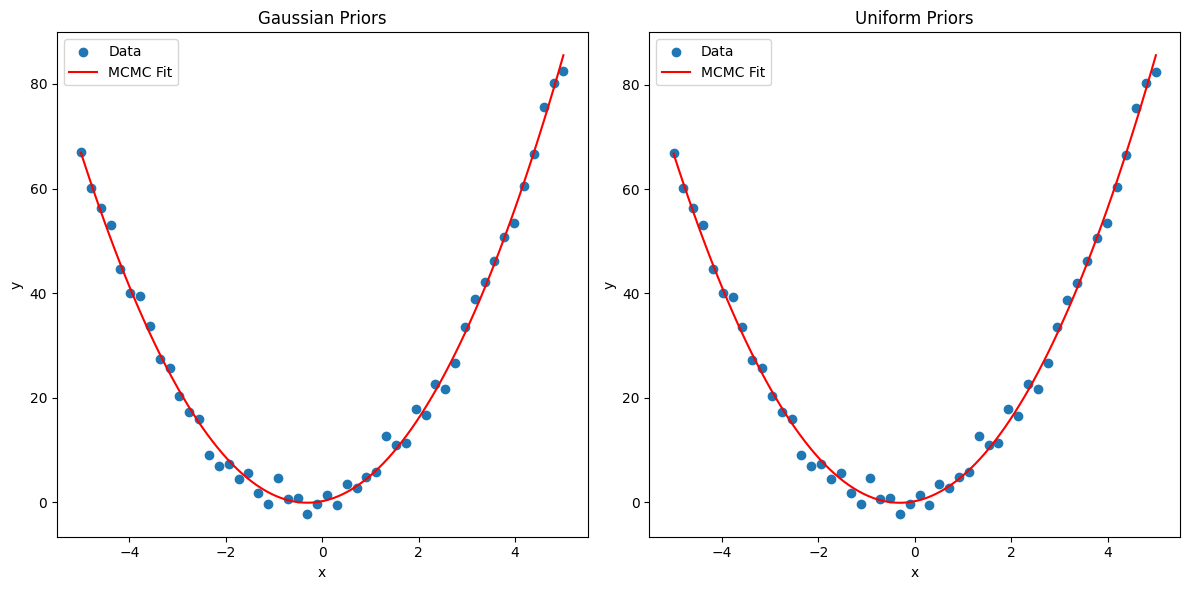

In [ ]:
plt.figure(figsize=(12, 6))

# gaussian priors
plt.subplot(1, 2, 1)
plt.scatter(x_data, y_data, label='Data')
x_fit = np.linspace(-5, 5, 100)
y_fit = mean_params1[0] * x_fit**2 + mean_params1[1] * x_fit + mean_params1[2]
plt.plot(x_fit, y_fit, color='red', label='MCMC Fit')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gaussian Priors")
plt.legend()

# uniform priors
plt.subplot(1, 2, 2)
plt.scatter(x_data, y_data, label='Data')
x_fit = np.linspace(-5, 5, 100)
y_fit = mean_params2[0] * x_fit**2 + mean_params2[1] * x_fit + mean_params2[2]
plt.plot(x_fit, y_fit, color='red', label='MCMC Fit')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Uniform Priors")
plt.legend()

plt.tight_layout()
plt.show()


Wow! Look's pretty good!

## 3.7: Sampling

Let's take a closer look at how our MCMC is sampling our parameters. We should see it oscillating around our mean value before it converges.

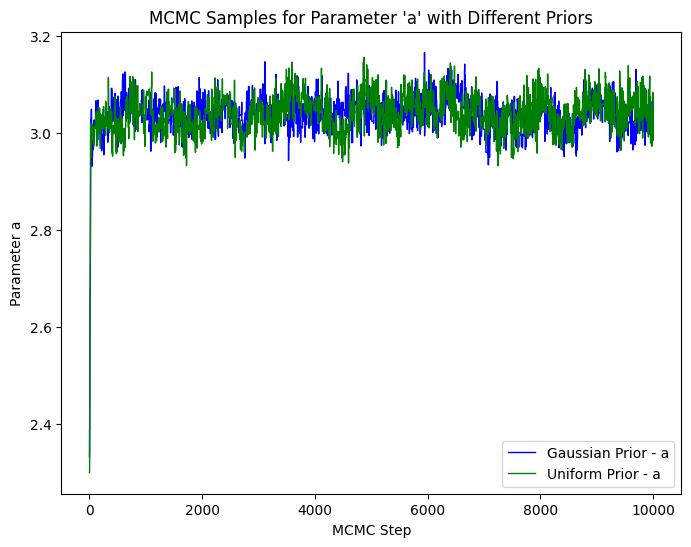

In [ ]:
plt.figure(figsize=(8, 6))

# plot gaussian and uniform prior samples for parameter 'a'
plt.plot(samples_gaussian[:, 0], label='Gaussian Prior - a', color='blue', linestyle='-', linewidth=1)
plt.plot(samples_uniform[:, 0], label='Uniform Prior - a', color='green', linestyle='-', linewidth=1)
plt.xlabel("MCMC Step")
plt.ylabel("Parameter a")
plt.title("MCMC Samples for Parameter 'a' with Different Priors")

plt.legend()
plt.show()


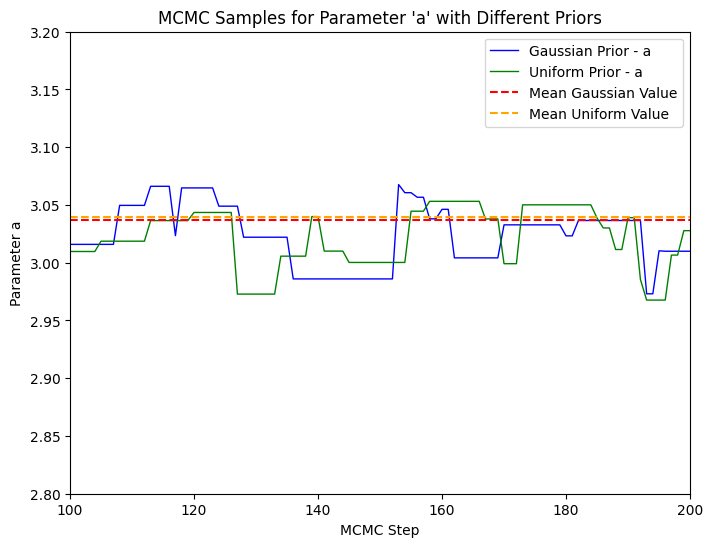

In [ ]:
plt.figure(figsize=(8, 6))

#zoom into plot above
plt.plot(samples_gaussian[:, 0], label='Gaussian Prior - a', color='blue', linestyle='-', linewidth=1)
plt.plot(samples_uniform[:, 0], label='Uniform Prior - a', color='green', linestyle='-', linewidth=1)
plt.axhline(y=np.mean(samples_gaussian[:, 0]), color='red', linestyle='--', label='Mean Gaussian Value')
plt.axhline(y=np.mean(samples_uniform[:, 0]), color='orange', linestyle='--', label='Mean Uniform Value')
plt.xlabel("MCMC Step")
plt.ylabel("Parameter a")
plt.title("MCMC Samples for Parameter 'a' with Different Priors")
plt.xlim(100, 200)
plt.ylim(2.8, 3.2)

plt.legend()
plt.show()


That oscilation is exactly what we were looking for! Look's like our MCMC sampler is working.

## 3.8: Posterior Distributions

Now that we are confident in our implimentation, we can move on to the analysis where we take a look at our posterior distributions. Let's compare our priors for parameter a from  above.

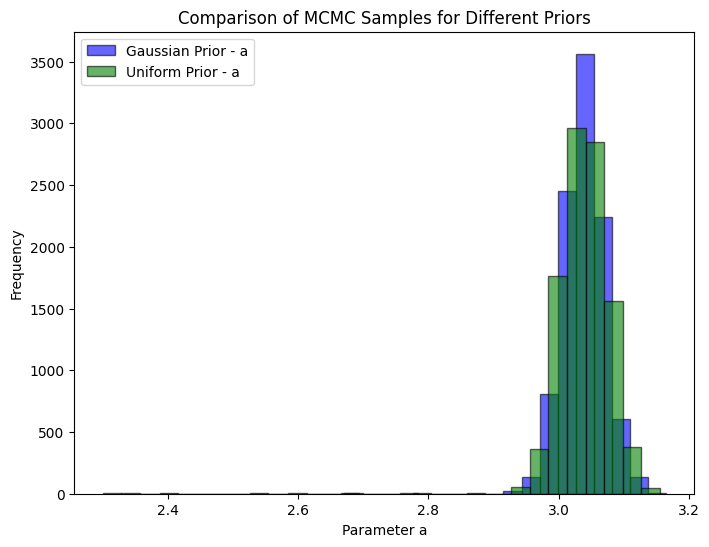

In [ ]:
plt.figure(figsize=(8, 6))

# plot hist of samples with different priors
plt.hist(samples_gaussian[:, 0], bins=30, alpha=0.6, label='Gaussian Prior - a', color='blue', edgecolor='black')
plt.hist(samples_uniform[:, 0], bins=30, alpha=0.6, label='Uniform Prior - a', color='green', edgecolor='black')
plt.xlabel("Parameter a")
plt.ylabel("Frequency")
plt.title("Comparison of MCMC Samples for Different Priors")
plt.legend()

plt.show()


## 3.9: Contour Maps

Interesting! The distribution of samples for parameter a appears to have the same general shape across different priors, meaning that both priors can characterize this parameter. To further analyze our posteriors, let's examine some contour maps to visualize how our parameters relate to each other.
What Do Contour Maps Show?

Contour maps are a way to represent the joint probability distribution of two parameters. Instead of looking at individual parameter distributions, we can see how two parameters vary together and where their highest probability densities lie.

In our contour plots:

  The x-axis represents parameter a, and the y-axis represents parameter b.

  The color intensity represents the density of samples, where darker blue areas indicate regions of higher probability—the values that our MCMC (Markov Chain Monte Carlo) sampler converges upon.

Now, let’s break down the process of creating these plots.

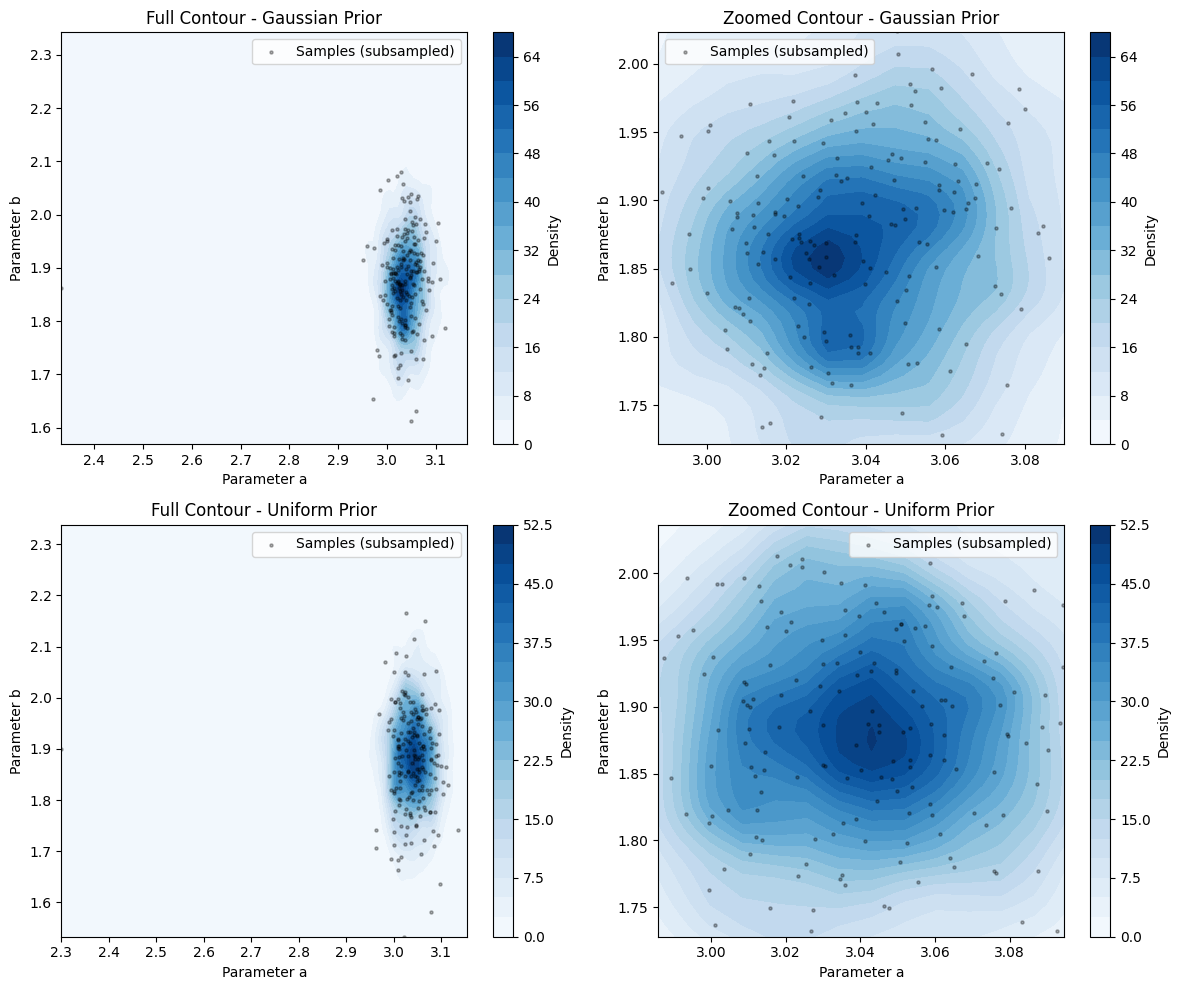

In [ ]:
# Extract parameters 'a' and 'b' from the MCMC samples for both Gaussian and Uniform priors
samples_a_gaussian = samples_gaussian[:, 0]  # First parameter 'a' from Gaussian prior
samples_b_gaussian = samples_gaussian[:, 1]  # Second parameter 'b' from Gaussian prior
samples_a_uniform = samples_uniform[:, 0]  # First parameter 'a' from Uniform prior
samples_b_uniform = samples_uniform[:, 1]  # Second parameter 'b' from Uniform prior

# Since the raw samples are scattered, we apply Kernel Density Estimation (KDE) to get a smoothed representation of the joint probability distribution
# Perform Kernel Density Estimation (KDE) to estimate probability density functions
kde_gaussian = gaussian_kde(np.vstack([samples_a_gaussian, samples_b_gaussian]))  # KDE for Gaussian prior samples
kde_uniform = gaussian_kde(np.vstack([samples_a_uniform, samples_b_uniform]))  # KDE for Uniform prior samples

# To visualize the density estimate, we need to evaluate it over a grid of (a, b) values
# Create a grid for plotting the density estimates
X_gaussian, Y_gaussian = np.meshgrid(
    np.linspace(min(samples_a_gaussian), max(samples_a_gaussian), 100),  # Range for 'a' parameter
    np.linspace(min(samples_b_gaussian), max(samples_b_gaussian), 100)   # Range for 'b' parameter
)
Z_gaussian = kde_gaussian(np.vstack([X_gaussian.ravel(), Y_gaussian.ravel()])).reshape(X_gaussian.shape)  # Compute density values

X_uniform, Y_uniform = np.meshgrid(
    np.linspace(min(samples_a_uniform), max(samples_a_uniform), 100),  # Range for 'a' parameter
    np.linspace(min(samples_b_uniform), max(samples_b_uniform), 100)   # Range for 'b' parameter
)
Z_uniform = kde_uniform(np.vstack([X_uniform.ravel(), Y_uniform.ravel()])).reshape(X_uniform.shape)  # Compute density values

# Determine the central 90% range of the sampled values (5th to 95th percentile) for zoomed-in plots
x_min_gaussian, x_max_gaussian = np.percentile(samples_a_gaussian, [5, 95])
y_min_gaussian, y_max_gaussian = np.percentile(samples_b_gaussian, [5, 95])

x_min_uniform, x_max_uniform = np.percentile(samples_a_uniform, [5, 95])
y_min_uniform, y_max_uniform = np.percentile(samples_b_uniform, [5, 95])

# Create a 2x2 subplot figure to visualize both priors (full and zoomed-in views)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Full contour plot for Gaussian prior
ax = axes[0, 0]
contour = ax.contourf(X_gaussian, Y_gaussian, Z_gaussian, levels=20, cmap='Blues')  # Filled contour plot
fig.colorbar(contour, ax=ax, label="Density")  # Add color bar to indicate density values
ax.scatter(samples_a_gaussian[::50], samples_b_gaussian[::50], s=5, color="black", alpha=0.3, label="Samples (subsampled)")  # Subsampled scatter plot for clarity
ax.set_xlabel("Parameter a")
ax.set_ylabel("Parameter b")
ax.set_title("Full Contour - Gaussian Prior")
ax.legend()

# Zoomed-in contour plot for Gaussian prior (focusing on central 90% range)
ax = axes[0, 1]
contour = ax.contourf(X_gaussian, Y_gaussian, Z_gaussian, levels=20, cmap='Blues')
fig.colorbar(contour, ax=ax, label="Density")
ax.scatter(samples_a_gaussian[::50], samples_b_gaussian[::50], s=5, color="black", alpha=0.3, label="Samples (subsampled)")
ax.set_xlabel("Parameter a")
ax.set_ylabel("Parameter b")
ax.set_title("Zoomed Contour - Gaussian Prior")
ax.set_xlim(x_min_gaussian, x_max_gaussian)  # Limit x-axis to central 90% of values
ax.set_ylim(y_min_gaussian, y_max_gaussian)  # Limit y-axis to central 90% of values
ax.legend()

# Full contour plot for Uniform prior
ax = axes[1, 0]
contour = ax.contourf(X_uniform, Y_uniform, Z_uniform, levels=20, cmap='Blues')
fig.colorbar(contour, ax=ax, label="Density")
ax.scatter(samples_a_uniform[::50], samples_b_uniform[::50], s=5, color="black", alpha=0.3, label="Samples (subsampled)")
ax.set_xlabel("Parameter a")
ax.set_ylabel("Parameter b")
ax.set_title("Full Contour - Uniform Prior")
ax.legend()

# Zoomed-in contour plot for Uniform prior (focusing on central 90% range)
ax = axes[1, 1]
contour = ax.contourf(X_uniform, Y_uniform, Z_uniform, levels=20, cmap='Blues')
fig.colorbar(contour, ax=ax, label="Density")
ax.scatter(samples_a_uniform[::50], samples_b_uniform[::50], s=5, color="black", alpha=0.3, label="Samples (subsampled)")
ax.set_xlabel("Parameter a")
ax.set_ylabel("Parameter b")
ax.set_title("Zoomed Contour - Uniform Prior")
ax.set_xlim(x_min_uniform, x_max_uniform)  # Limit x-axis to central 90% of values
ax.set_ylim(y_min_uniform, y_max_uniform)  # Limit y-axis to central 90% of values
ax.legend()

# Adjust layout to prevent overlapping elements
plt.tight_layout()
plt.show()


**What Does np.vstack() Do?**

np.vstack() stacks arrays vertically (along a new axis). In this case it creates a 2D array where:

* The first row contains all values of a

* The second row contains all values of b

This format is required for gaussian_kde(), which estimates the joint density of both parameters.

**What Does np.meshgrid() Do?**

np.meshgrid() creates coordinate grids from two 1D arrays.

* The first array spans parameter a’s range.

* The second array spans parameter b’s range.

This results in two 2D arrays, X_gaussian and Y_gaussian, which define a grid of (a, b) points where the density will be evaluated.

**What Does ravel() Do?**

X_gaussian.ravel() flattens the 2D grid into a 1D array so it can be used for density evaluation.

**What Does reshape() Do?**

After evaluating the density at each grid point, we reshape it back into the original (100, 100) grid format for contour plotting.

## 3.10: Evaluate the Model

### 3.10.1: Plotting the Residuals


Cool! Now that we know how to visualize the relationship between parameters and understand what our posterior distribution is describing, let's evaluate the quality of our model. To evaluate how well our model fits the data, we can visualize the residuals (the differences between the observed data and the fitted model). The residuals should ideally be randomly scattered around zero if the model fits the data well.


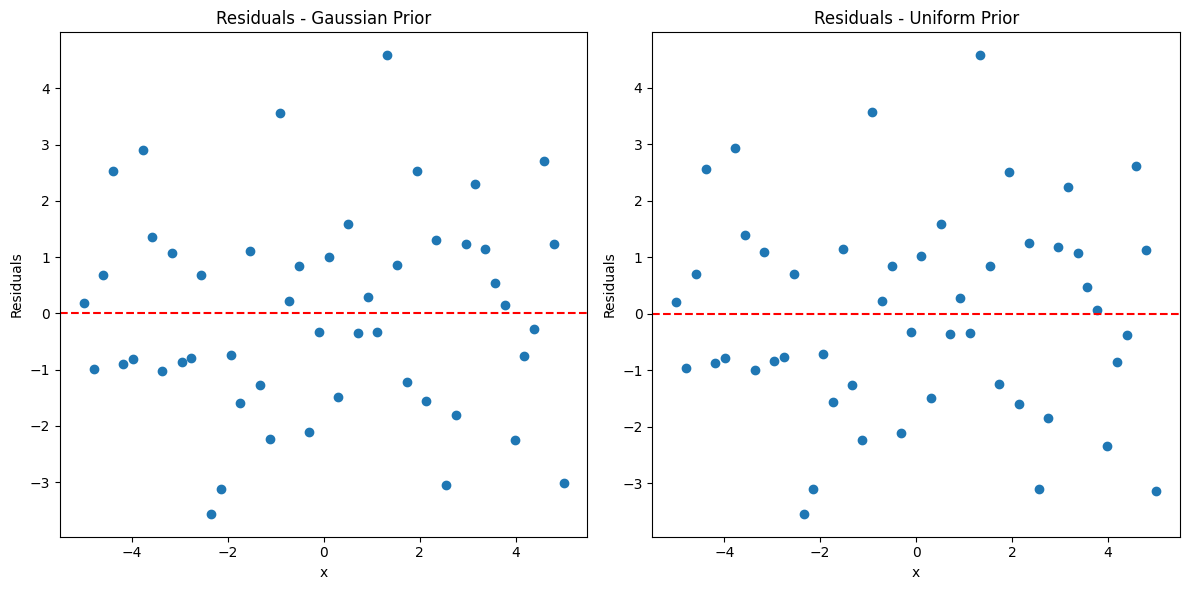

In [ ]:
#residuals
# these are the data points (observed) minus the prediction (our fitted data)
# one of them is from the gaussian prior, and the other is from uniform prior
residuals1 = y_data - (mean_params1[0] * x_data**2 + mean_params1[1] * x_data + mean_params1[2])
residuals2 = y_data - (mean_params2[0] * x_data**2 + mean_params2[1] * x_data + mean_params2[2])

plt.figure(figsize=(12, 6))

#residuals for gaussian
plt.subplot(1, 2, 1)
plt.scatter(x_data, residuals1)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("x")
plt.ylabel("Residuals")
plt.title("Residuals - Gaussian Prior")

#residuals for uniform
plt.subplot(1, 2, 2)
plt.scatter(x_data, residuals2)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("x")
plt.ylabel("Residuals")
plt.title("Residuals - Uniform Prior")

plt.tight_layout()
plt.show()

Nice! The random scatter is exactly what we expected.

### 3.10.2: Calculating the Chi-Squared and the Reduced Chi-Squared


Now, we calculate the **Chi-squared** statistic and the **Reduced Chi-squared**. Further description of how to interpret these values can be found below this cell of code:

In [ ]:
best_fit_sigma1 = np.mean(mean_params1[3])
chi_squared1 = np.sum((residuals1)**2/best_fit_sigma1**2)
degrees_of_freedom = len(y_data) - len(mean_params1)  #number of data points minus number of parameters
reduced_chi_squared1 = chi_squared1 / degrees_of_freedom

print("Chi-squared with Gaussian Prior: " + str(chi_squared1))
print("Reduced Chi-squared with Gaussian Prior: " + str(reduced_chi_squared1))

best_fit_sigma2 = np.mean(mean_params2[3])
chi_squared2 = np.sum((residuals2)**2/best_fit_sigma2**2)
degrees_of_freedom = len(y_data) - len(mean_params2)  #number of data points minus number of parameters
reduced_chi_squared2 = chi_squared2 / degrees_of_freedom

print("Chi-squared with Uniform Prior: " + str(chi_squared2))
print("Reduced Chi-squared with Uniform Prior: " + str(reduced_chi_squared2))


Chi-squared with Gaussian Prior: 49.20743633459855
Reduced Chi-squared with Gaussian Prior: 1.0697268768390988
Chi-squared with Uniform Prior: 43.42684009534086
Reduced Chi-squared with Uniform Prior: 0.9440617412030621


## 3.11: Discussion
### Priors: Gaussian and Uniform
After calculating the **Chi-squared** and **Reduced Chi-squared** values for both Gaussian and Uniform priors, we obtained the following results:

- **Chi-squared with Gaussian Prior**: 49.21
- **Reduced Chi-squared with Gaussian Prior**: 1.06
- **Chi-squared with Uniform Prior**: 43.4
- **Reduced Chi-squared with Uniform Prior**: 0.944

### Chi-squared Interpretation:
The **Chi-squared** value measures the total squared deviation between the observed data and the fitted model, normalized by the error. Both the Gaussian and Uniform prior models give similar Chi-squared values ranging from 43-50, which are relatively large. This suggests that there is a notable discrepancy between the observed data and the fitted models, indicating that neither model perfectly captures the data.

### Reduced Chi-squared Interpretation:
The **Reduced Chi-squared** is calculated by dividing the Chi-squared value by the degrees of freedom (the number of data points minus the number of fitted parameters). Both priors give a **Reduced Chi-squared** of 0.9-1.1, which is really good!
In general:
- A **Reduced Chi-squared** close to 1 indicates a good fit.
- A **Reduced Chi-squared** much greater than 1 suggests that the model might be underfitting the data meaning our model wasn't a good fit or the uncertainties were underestimated.
- A **Reduced Chi-squared** much less than 1 suggests that the model might be overfitting the data and taking the uncertainties are having too much of an influence on our model.

### Comparison of Priors:
Both the Gaussian and Uniform priors yield very similar **Chi-squared** and **Reduced Chi-squared** values, indicating that the choice of prior does not substantially affect the overall fit of the model in this case.

### Conclusion:
Due to our Reduced Chi-squared values being $\approx$ 1, we can claim, with statistical significance that our model:

$$
y = ax^2 + bx + c
$$

with the following parameters:

**Gaussian Priors**

$$a_{gaussian} = 3.0371715947214035$$

$$b_{gaussian} = 1.868119900337486$$

$$c_{gaussian} = 0.22445957102291067$$

$$\sigma_{gaussian} = 1.8016297955926162$$

**Uniform Priors**

$$a_{uniform} = 3.0394010365013373$$

$$b_{uniform} = 1.882243857311537$$

$$c_{uniform} = 0.21937185884795382$$

$$\sigma_{uniform} = 1.9168187040324995$$

provides good a good fit for our data.

# 4.0: Example 2: Apply our MCMC to CM Draconis


---

## 4.1: CM Draconis

In our previous tutorials we have worked with the binary star system CM Draconis! Let's continue our analysis of the system by trying to fit the spot modulation from Assignment 3. Here is a quick recap of the binary star system CM Draconis:

A **binary star system** is a system of two stars that revolve around a common center of mass. CM Draconis is one of these systems. If said system is known as an **eclipsing binary star system** then there are moments within the orbit that one of the stars blocks the other. Efficiently dimming the brightness of the system so long as we are in the position to observe it.

CM Draconis is the eclipsing binary star system we will be analysing today. It consists of two **M dwarfs**. As we will see, the two stars are of roughly the same mass and are nearly identical. The literature values that characterize this binary are the following:

### *Orbital and Stellar Parameters*

- **Period**: 1.2683900573 days  
- **Inclination**: 89.5514°  
- **Impact parameter $b$**: 0.11711    
- **Radius (Primary)**: 0.25113 $R_\odot$
- **Radius (Secondary)**: 0.23732 $R_\odot$  
- **Mass (Primary)**: 0.22507 $M_\odot$  
- **Mass (Secondary)**: 0.21017 $M_\odot$  
- **Semi-major axis**: 0.0173945 AU  
- **Eccentricity**: 0.00527
- **Argument of periapse**: 107.98°  

### *Identifiers*

- **TIC**: 199 574 208  
- **Gaia ID**: 1431176943768690816  

To examine the spot modulation we will be taking a look at the **light curve** of CM Draconis.

### *What is a Light Curve?*

A light curve is **photometric data** used to characterize celestial objects. In simpler terms, it represents the **brightness of an object over time** (flux).  

### Spot Modulation

**Spot modulation**, in this context, is defined as perturbation in the light curve due to **star spots**. This perturbation looks quasi-sinusoidal where the periodicity of the sine curves relate directly to the rotational period of the stars.

Let's read-in our data:

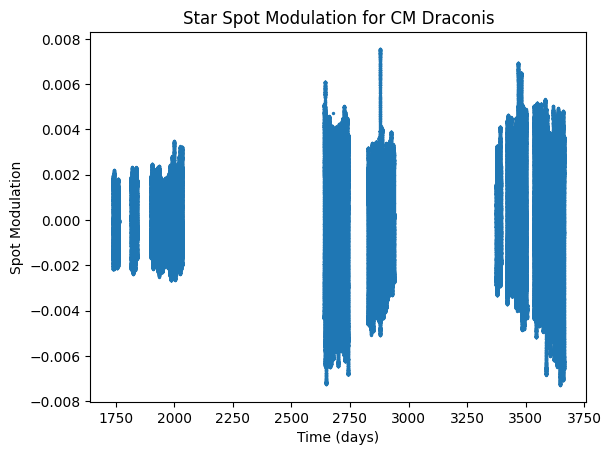

In [ ]:
#load in flare and spot data
spots = pd.read_csv("spot_modulation.csv", header = None)
timeSpotsData = spots.iloc[:, 0]
fluxSpotsData = spots.iloc[:, 1]

#plot
plt.scatter(timeSpotsData, fluxSpotsData, s=2)
plt.xlabel('Time (days)')
plt.ylabel('Spot Modulation')
plt.title('Star Spot Modulation for CM Draconis')
plt.show()

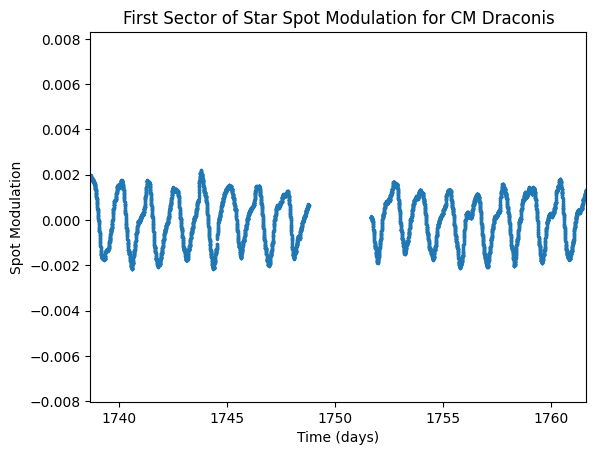

In [ ]:
#zoom-in
plt.scatter(timeSpotsData, fluxSpotsData, s = 2)
plt.xlim(timeSpotsData[0], timeSpotsData[0]+23)
plt.xlabel('Time (days)')
plt.ylabel('Spot Modulation')
plt.title('First Sector of Star Spot Modulation for CM Draconis')
plt.show()

This data looks a little difficult to fit, specifically due to the data gaps within the light curve. Let's try and fit the first chunk of this data so that we can create an accurate model that will properly characterize the system.

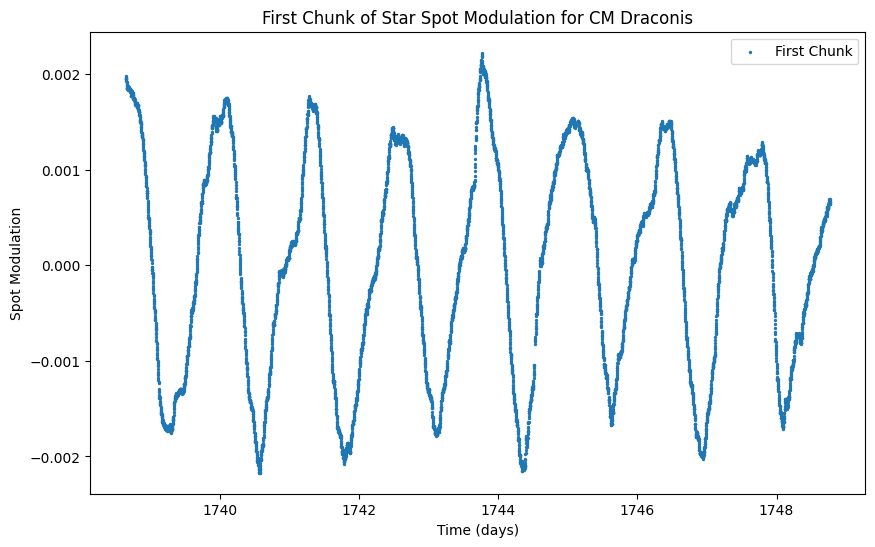

In [ ]:
#find the index of the first large data gap (threshold of 1 day)
gap_indices = np.where(np.diff(timeSpotsData) > 1)[0]
first_gap_index = gap_indices[0] +1 # index + 1 because np.diff gives index of the difference, not the end of the first chunk
first_chunk_time = timeSpotsData[:first_gap_index]
first_chunk_flux = fluxSpotsData[:first_gap_index]

#plotting the first chunk
plt.figure(figsize=(10, 6))
plt.scatter(first_chunk_time, first_chunk_flux, s=2, label="First Chunk")
plt.xlabel("Time (days)")
plt.ylabel("Spot Modulation")
plt.title("First Chunk of Star Spot Modulation for CM Draconis")
plt.legend()
plt.show()


Perfect! This is what we are going to be applying our MCMC to. As stated earlier, this data is **quasi-sinusoidal** meaning it resembles a sine curve. More specifically, this data seems to resemble the addition of two sine curves so we add two sine curves together and include an offset term on the end (e) which will account for any sort of vertical shifting (although this part is optional given the data we have seems to be normalized around 0). This means that our chosen model is the following:

$$
y = a \cdot sin(b \cdot x + \phi_{1}) + c \cdot sin(d \cdot x + \phi_{2}) + e
$$

where:

$$a: \text{the amplitude of the larger wave}$$

$$b: \text{the frequency of the larger wave}$$

$$\phi_1: \text{the phase shift of the larger wave}$$

$$c: \text{the amplitude of the smaller wave}$$

$$d: \text{the frequency of the smaller wave}$$

$$\phi_2: \text{the phase shift of the smaller wave}$$

$$e: \text{the offset}$$

$$\sigma: \text{the noise level}$$


In [ ]:
#define model
#note that any models used with our tools in this notebook must be named myModel()
def myModel(theta, x):
    a, b, phi1, c, d, phi2, e, sigma = theta
    return a * np.sin(b * x + phi1) + c * np.sin(d * x + phi2) + e


## 4.2: Discussing Priors

We also need to define our prior dictionary. We choose log-normal distributions to model the flux amplitudes and the noise level and gaussian distributions to model frequency of the waves, the phase shift, and the offset. With the tools of this notebook, you can choose any prior distribution so long as you define the **probability density function (pdf)** and put it in the dictionary that you read into the mcmc_sampler(). You should be defining your prior distribution based on the physicalities of your system. For example, if you are trying to fit a light curve and you need to take into consideration the **eccentricity** of an orbit (how much the shape of the orbit deviates from a perfect circle), you need to think about the fact that eccentricity values span 0 to 1. This means you should define a function bound between these values as your prior so that you don't return anything non-physical. Choose wisely!


In [ ]:
#define our prior dictionary
priors_spot_modulation = {
    #amplitude of the larger wave (a)
    'param_0': lambda a: log_normal_prior(a, np.log(0.0013), 2.0),
    #frequency (b) of the larger wave
    'param_1': lambda b: gaussian_prior(b, 2*np.pi/1.26, 2.0),
    #phase shift (phi1) for the larger wave
    'param_2': lambda phi1: gaussian_prior(phi1, np.pi/2, 2.0),
    #amplitude of the smaller wave (c)
    'param_3': lambda c: log_normal_prior(c, np.log(0.0006), 2.0),
    #frequency (d) for the smaller wave (usually present at harmonics of first wave)
    'param_4': lambda d: gaussian_prior(d, 4*np.pi/1.26, 4.0),
    #phase shift (phi2) for the smaller wave
    'param_5': lambda phi2: gaussian_prior(phi2, np.pi/4, 2.0),
    #offset (e)
    'param_6': lambda e: gaussian_prior(e, 0, 0.005),
    # noise level (sigma)
    'param_7': lambda sigma: log_normal_prior(sigma, np.log(0.001), 2.0)
}

## 4.3: Applying MCMC

Now, we are ready to apply our MCMC as we did above to the quadratic data. We are going to sample each parameter 20000 times with a step size of 1E5 to increase our acceptance rate.

In [ ]:
#initial guess
initial_theta = [0.0013, 2*np.pi/1.26, np.pi/2, 0.0006, 4*np.pi/1.26, np.pi/4, 0, 0.001]

#sample using MCMC
n_samples = 20000
step_size = 1E-5
samples = mcmc_sampler(initial_theta, first_chunk_time, first_chunk_flux, n_samples, step_size, priors_spot_modulation)

#extract parameters
a_samples, b_samples, phi1_samples, c_samples, d_samples, phi2_samples, e_samples, sigma_samples = samples.T

# compute best-fit model
best_fit_theta = np.mean(samples, axis=0)
linear_time = np.linspace(min(first_chunk_time), max(first_chunk_time), 1000)
best_fit_model_linear_time = myModel(best_fit_theta, linear_time)
best_fit_model = myModel(best_fit_theta, first_chunk_time)



Acceptance rate: 0.0155


## 4.4: Plotting the Fit

Now, let's plot our fit!

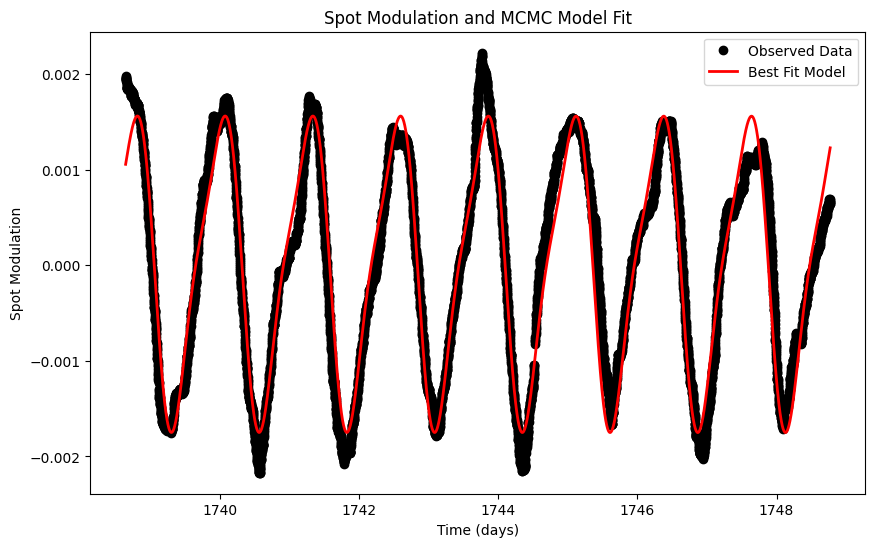

a : 0.0015274456670647386
b : 4.986834850997936
phi1 : 1.5707415064853394
c : 0.0003538315523951751
d : 9.973027856480977
phi2 : 0.7853007361216316
e : -5.434188002891488e-06
sigma : 0.00029352222099736684


In [ ]:
#plot
plt.figure(figsize=(10, 6))
plt.plot(first_chunk_time, first_chunk_flux, 'ko', label='Observed Data')  # Plot observed data
plt.plot(first_chunk_time, best_fit_model, label='Best Fit Model', color='r', lw=2)
plt.xlabel('Time (days)')
plt.ylabel('Spot Modulation')
plt.title('Spot Modulation and MCMC Model Fit')
plt.legend()
plt.show()

# Print parameter means
parameter_names = ['a', 'b', 'phi1', 'c', 'd', 'phi2', 'e', 'sigma']

for i in range(len(parameter_names)):
    mean = np.mean(samples[:, i])
    print(str(parameter_names[i]) + " : " + str(mean))


By observation, it looks like we have a pretty good fit!

## 4.5: Sampling

Now, we will plot the sampling of one of the parameters as we did for the quadratic example above. Let's look and see if the osciallation that we want is present. This will verify that our MCMC is working:

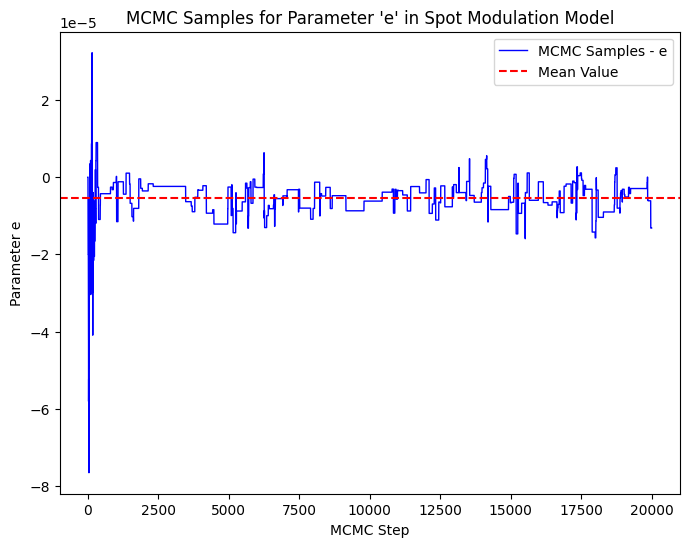

In [ ]:
#figure size
plt.figure(figsize=(8, 6))

#plot MCMC samples for parameter E
plt.plot(e_samples, label="MCMC Samples - e", color="blue", linestyle="-", linewidth=1)

#plot line at actual parameter
plt.axhline(y=np.mean(e_samples), color='red', linestyle='--', label='Mean Value')
plt.xlabel("MCMC Step")
plt.ylabel("Parameter e")
plt.title("MCMC Samples for Parameter 'e' in Spot Modulation Model")

#legend
plt.legend()
plt.show()

Perfect! We are oscillating as we expected.

## 4.6: Posterior Distributions

Now, let's take a look at our posterior distributions.

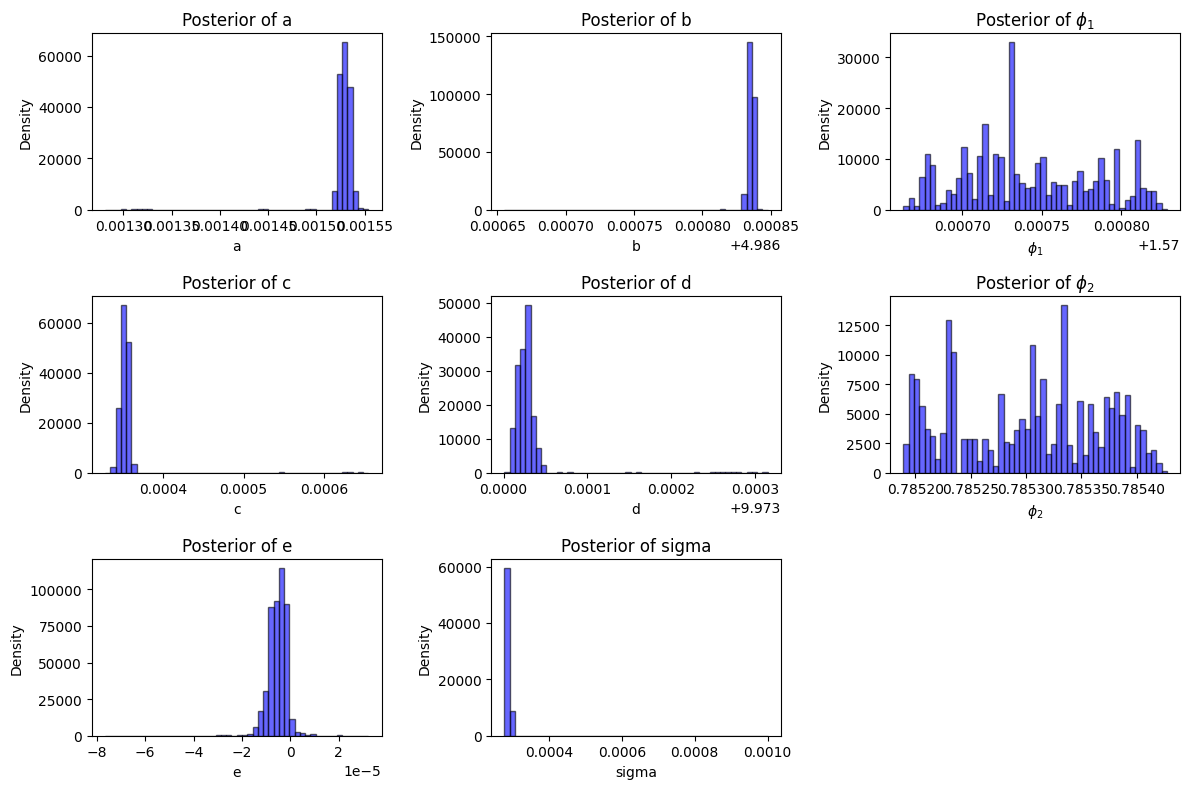

In [ ]:
# Define parameter names
parameter_names = ['a', 'b', '$\phi_1$', 'c', 'd', '$\phi_2$', 'e','sigma']
samples_list = [a_samples, b_samples, phi1_samples, c_samples, d_samples, phi2_samples, e_samples, sigma_samples]

plt.figure(figsize=(12, 8))

# Plot each parameter's posterior distribution
for i, (param_name, samples) in enumerate(zip(parameter_names, samples_list), 1):
  plt.subplot(3, 3, i)  # Create subplots in a grid
  plt.hist(samples, bins=50, density=True, color='blue', alpha=0.6, edgecolor='black')  # Histogram
  plt.xlabel(param_name)
  plt.ylabel("Density")
  plt.title(f"Posterior of {param_name}")

plt.tight_layout()
plt.show()

These look good! As stated in **Section 3.3**, posteriors are a proportional to the multiplication of priors and likelihood. We have gaussian priors defined for parameters b, $\phi_1$, $\phi_2$, d, and e as well as a gaussian likelihood model. This leads to a gaussian distribution for the posteriors. This makes our priors for these parameters **conjugate priors** or priors that when related to the posteriors via the likelihood, produce a distribution in the same family. The same cannot be said for the other parameters a, c, and $\sigma$, as the likelihood still follows a gaussian distribution, but the prior distributions are log-normal, resulting in a skewed log-generalized hyperbolic function (this would be more pronounced given wider sampling).

## 4.7: Contour Maps

Next, we visualize the relationship between our parameters by plotting our contour plots.

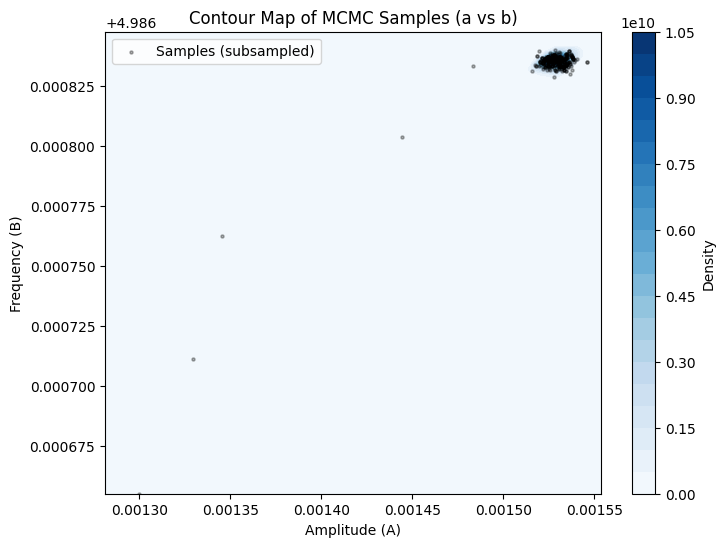

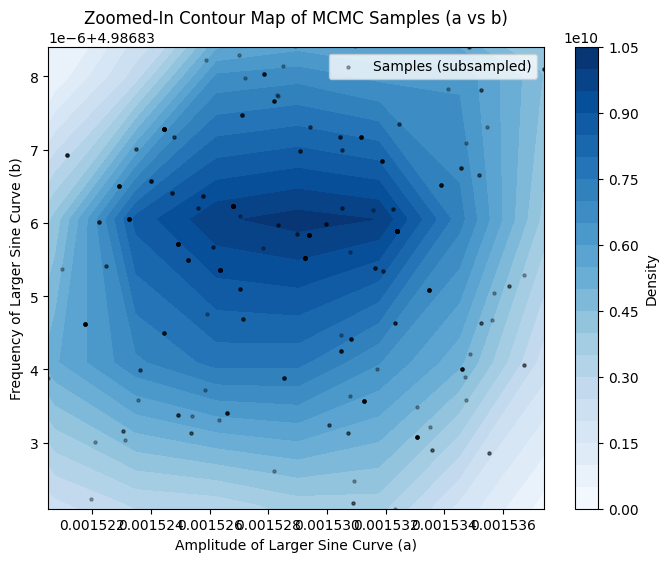

In [ ]:
#perform Kernel Density Estimation (KDE)
kde = gaussian_kde(np.vstack([a_samples, b_samples]))
X, Y = np.meshgrid(np.linspace(min(a_samples), max(a_samples), 100), np.linspace(min(b_samples), max(b_samples), 100))
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

#plot the full contour map of the estimated density
plt.figure(figsize=(8,6))
plt.contourf(X, Y, Z, levels=20, cmap='Blues')  # Filled contour plot
plt.colorbar(label="Density")

#scatter plot of the samples (subsampled)
plt.scatter(a_samples[::50], b_samples[::50], s=5, color="black", alpha=0.3, label="Samples (subsampled)")

#label axes and title
plt.xlabel("Amplitude (A)")
plt.ylabel("Frequency (B)")
plt.title("Contour Map of MCMC Samples (a vs b)")
plt.legend()
plt.show()

#zoom in focused on central 90%
x_min, x_max = np.percentile(a_samples, [5, 95])  # Get 5th and 95th percentile for A
y_min, y_max = np.percentile(b_samples, [5, 95])  # Get 5th and 95th percentile for B

#plot the zoomed-in contour map
plt.figure(figsize=(8,6))
plt.contourf(X, Y, Z, levels=20, cmap='Blues')
plt.colorbar(label="Density")
plt.scatter(a_samples[::50], b_samples[::50], s=5, color="black", alpha=0.3, label="Samples (subsampled)")

#label axes and title
plt.xlabel("Amplitude of Larger Sine Curve (a)")
plt.ylabel("Frequency of Larger Sine Curve (b)")
plt.title("Zoomed-In Contour Map of MCMC Samples (a vs b)")

#szet limits to zoom in on the central region of the distribution
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

#legend
plt.legend()
plt.show()

It looks like we have a wider range of successful amplitudes than frequecies. You can tell because the shape of the contour plot is somewhat of an elongated oval where the semi-minor axis is showing the range of best fit frequencies and the semi-major axis is describing the range of the best fit amplitudes. You can plot any parameter against another in order to better characterize the relationship between them.

## 4.8: Statistical Evaluation of Model

Finally, we can evaluate our model.

In [ ]:
#evaluate your best-fit model
best_fit_model = myModel(best_fit_theta, first_chunk_time)

#extract the best-fit noise
best_fit_sigma = best_fit_theta[-1]

#calculate chi-squared
chi2 = np.sum(((first_chunk_flux - best_fit_model)**2 / best_fit_sigma**2))

#number of data points
N = len(first_chunk_flux)

# degrees of freedom (number of parameters within the model)
k = 8  #a, b, phi1, c, d, phi2, e, sigma

# reduced chi-squared
reduced_chi2 = chi2 / (N - k)

print("Chi-squared:", chi2)
print("Reduced Chi-squared:", reduced_chi2)


Chi-squared: 7023.595271857281
Reduced Chi-squared: 0.9722584817078185


Woah! That is an incredibly high chi-squared value. This is probably due to the fact that our model is quite complex and the chi-squared value has a tendency to increase as models become more complicated (i.e. have more parameters). Given we have 8 parameters that we are fitting for, this is not surprising.  However, before attempting a re-run with another model, be sure to take a look at the **reduced** chi-squared value which takes into consideration the proposed model's complexity. Our reduced chi-squared value is $\approx$ 1 which is the benchmark for a good fit! If anything, we are slightly **overfitting** the data given that we are below 1. However, our deviation is so slight that we can claim, with statistical significance, that the following model:

 $$
y = a \cdot sin(b \cdot x + \phi_{1}) + c \cdot sin(d \cdot x + \phi_{2}) + e
$$

with the following parameters:

$$a : 0.0015274456670647386$$

$$b : 4.986834779022308$$

$$\phi_1: 1.5707415064853394$$

$$c : 0.0003538315523951751$$

$$d : 9.973027856480977$$

$$\phi_2: 0.7853007361216316$$

$$e : -5.434188002891488\text{e-06}$$

$$\sigma : 0.00029352222099736684$$

accurately characterizes the spot modulation of CM Draconis.